<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/FINAL_WORKING_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RASTERIO

In [ ]:
!pip install rasterio
import rasterio
from rasterio.windows import Window
import os
import numpy as np
from PIL import Image


### RASTERIO - 1 BAND MASK

In [ ]:
# Create a folder named "images" if it doesn't exist
folder_name = "labels1"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Open the input raster file
with rasterio.open('mask_reclass.tif') as src:

    # Calculate the height and width of the sub-rasters
    height = src.height // 20  # Divide the raster into 4 rows
    width = src.width // 8  # Divide the raster into 8 columns

    # Loop through each sub-raster and clip the data
    for i in range(20):
        for j in range(8):
            # Define the window to clip the sub-raster
            ymin = i * height
            ymax = (i + 1) * height
            xmin = j * width
            xmax = (j + 1) * width
            window = Window.from_slices((ymin, ymax), (xmin, xmax))

            # Read the data within the window
            clipped_data = src.read(window=window)

            # Update the metadata for the clipped data
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                'height': window.height,
                'width': window.width,
                'transform': src.window_transform(window)
            })

            # Write the clipped data to a new raster file
            # with rasterio.open(f'sub_raster_{i}_{j}.tif', 'w', **clipped_meta) as dst:
            #     dst.write(clipped_data)
            output_file = os.path.join(folder_name, f'image_{i}_{j}_mask1.png')
            with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                 dst.write(clipped_data)

### RASTERIO - 3 BANDS IMAGE

In [ ]:
# converts to 8 bits AFTER re-scaling bands
def s255(arr):
    arr_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    # Convert the standardized array to integer values
    arr_std = arr_std.astype(np.uint8)
    return arr_std


# Create a folder named "images" if it doesn't exist
folder_name = "images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Multi bandas
# Open the input raster file
with rasterio.open(r'3bands_clipped_tif.tif') as src:

    # Calculate the height and width of the sub-rasters
    nHeight=20
    nWidth=8
    height = src.height // nHeight  # Divide the raster into 58 rows
    width = src.width // nWidth  # Divide the raster into 23 columns

    # Loop through each sub-raster and clip the data
    for i in range(nHeight):
        for j in range(nWidth):
            # Define the window to clip the sub-raster
            ymin = i * height
            ymax = (i + 1) * height
            xmin = j * width
            xmax = (j + 1) * width
            #print(ymin, ymax,xmin, xmax)
            window = Window.from_slices((ymin, ymax), (xmin, xmax))

            # Read the data within the window
            clipped_data_1 = s255(src.read(1, window=window))
            clipped_data_2 = s255(src.read(2, window=window))
            clipped_data_3 = s255(src.read(3, window=window))
            #clipped_data = src.read().astype(np.uint8)
            #print(clipped_data_1.shape)
            #print('clipped_data.shape', clipped_data.shape)
            # Stack the bands to create an RGB image array
            rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)
            #rgb_image = np.stack([clipped_data_2, clipped_data_2, clipped_data_2], axis=2)
            #print('rgb_image.shape', rgb_image.shape)
            #rgb_image = clipped_data
            #print(rgb_image)

            # Convert the image array to a PIL Image
            image = Image.fromarray(rgb_image,mode='RGB')

            # Save the PIL Image as a PNG file
            #output_file = f'image_{i}_{j}.png'
            #image.save(output_file) 
            output_file = os.path.join(folder_name, f'image_{i}_{j}.png')
            image.save(output_file)

## IMAGE SEGMENTATION

In [2]:
from fastai.vision.all import *
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define paths
path = Path('/content/drive/MyDrive/AAA') #ADJUST TO YOUR OWN PATH
image_folder = path/'images'
mask_folder = path/'labels1'

# Create DataBlock
def get_items(path):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    return mask_folder / f'{image_file.stem}_mask1.png'

codes = ['object', 'background']  # Labels in the mask

dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(path, bs=8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.7MB/s]


epoch,train_loss,valid_loss,time
0,0.404936,0.363387,00:48


epoch,train_loss,valid_loss,time
0,0.383053,0.364578,00:51
1,0.355161,0.344285,00:57


<Axes: >

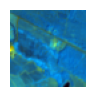

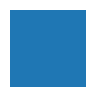

In [5]:
# Define U-Net model
learn = unet_learner(dls, resnet34)

# Train the model
learn.fine_tune(2)

# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder))
preds = learn.get_preds(dl=test_dl)

# Display sample predictions
sample_idx = 0
sample_image_path = list(test_dl.items)[sample_idx]
sample_image = PILImage.create(sample_image_path)
sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

sample_image.show()
TensorImage(sample_pred).show(cmap='tab20')


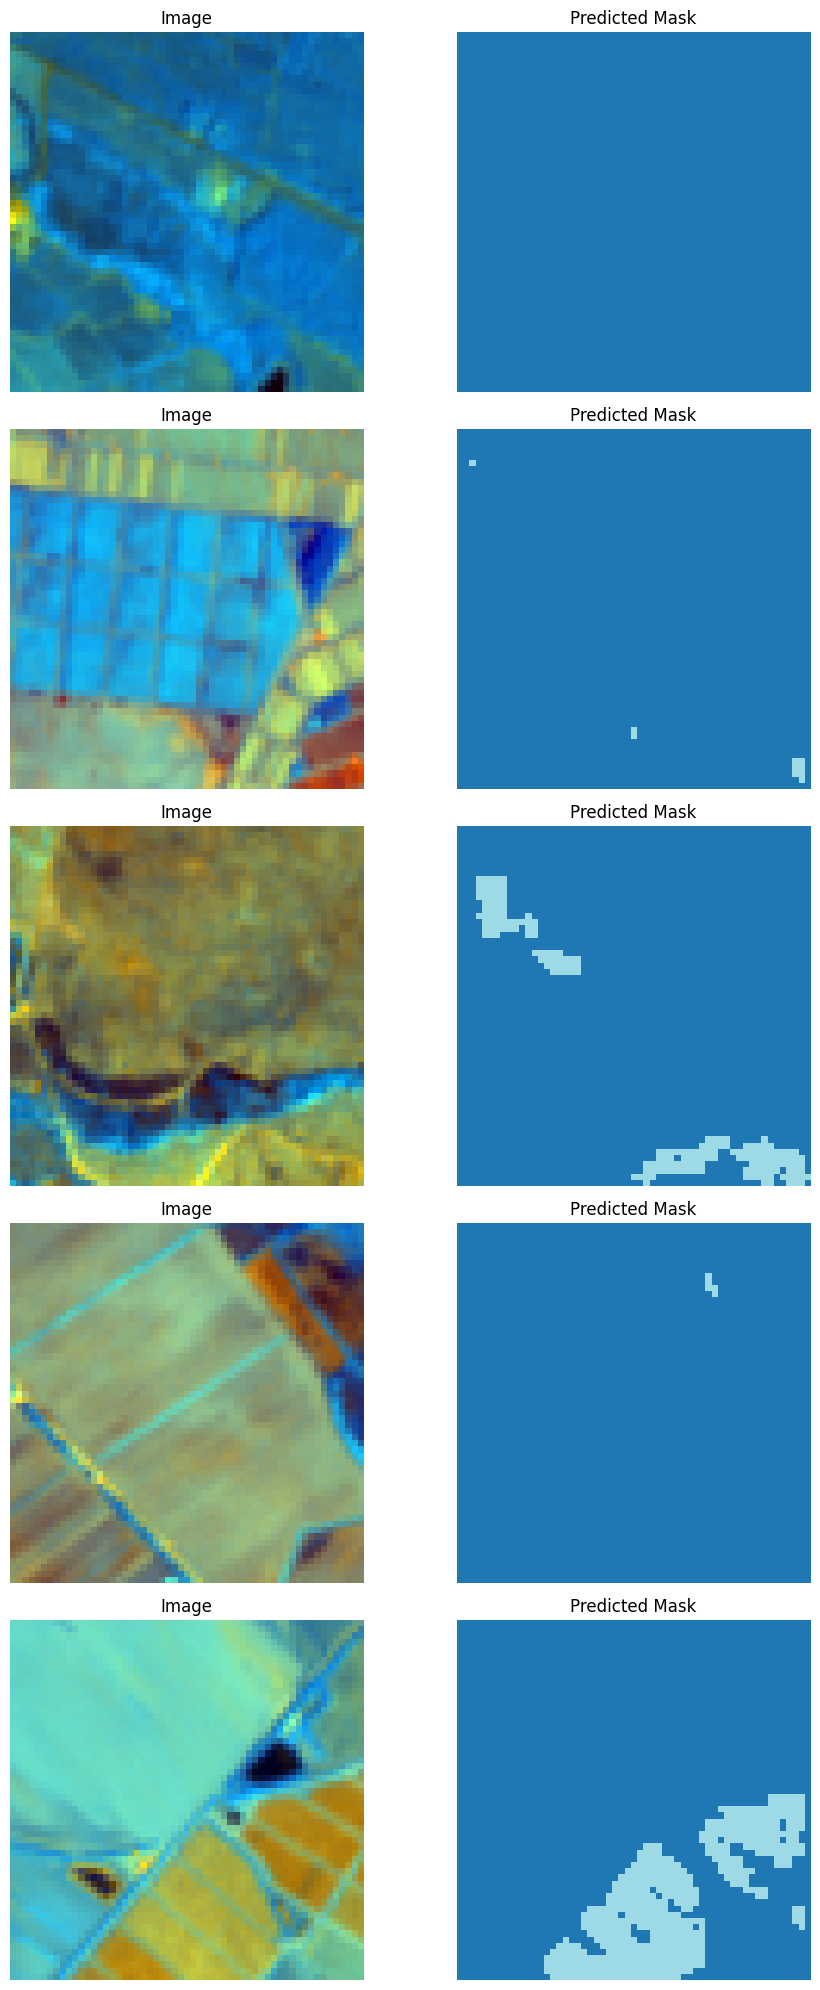

In [6]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder))
preds = learn.get_preds(dl=test_dl)[0]

# Display sample predictions
sample_indices = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i, idx in enumerate(sample_indices):
    sample_image_path = list(test_dl.items)[idx]
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[idx].argmax(dim=0).numpy()

    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(sample_pred, cmap='tab20')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

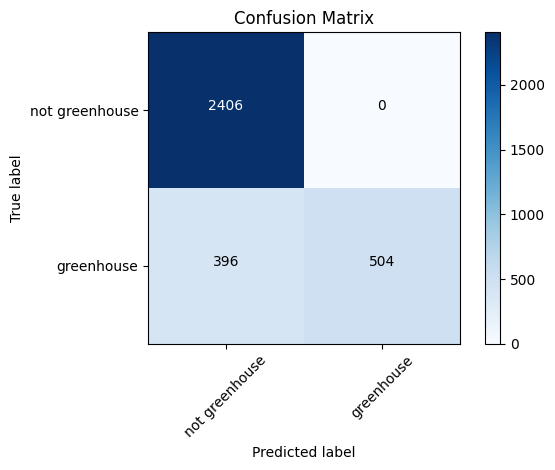

In [7]:
from sklearn.metrics import confusion_matrix

# Convert predicted and ground truth labels to 1D arrays
pred_labels = sample_pred.flatten()
true_labels = np.array(Image.open(get_mask_fn(sample_image_path))).flatten()

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
classes = ['not greenhouse', 'greenhouse']

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Fill in confusion matrix with values
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()

In [8]:
# Compute confusion matrix

from sklearn.metrics import classification_report
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      2406
         1.0       1.00      0.56      0.72       900

    accuracy                           0.88      3306
   macro avg       0.93      0.78      0.82      3306
weighted avg       0.90      0.88      0.87      3306



In [9]:
from sklearn.metrics import roc_auc_score

# Compute the AUC score
auc_score = roc_auc_score(true_labels, pred_labels)
print("AUC:", auc_score)
     

AUC: 0.78
